### Import

In [2]:
# configure paths for proper import 
import sys
import os
file_dir = os.getcwd()
package_dir = os.path.split(os.path.split(file_dir)[0])[0]
sys.path.insert(0, package_dir)
#file_directory = os.path.dirname(os.path.abspath(__file__))
#parent_directory = os.path.split(file_directory)[0]


In [3]:
import numpy as np
import torch
import time
import pandas as pd

import json

import matplotlib.pyplot as plt

import deblending_runjingdev.simulated_datasets_lib as simulated_datasets_lib
import deblending_runjingdev.sdss_dataset_lib as sdss_dataset_lib
import deblending_runjingdev.starnet_lib as starnet_lib
import deblending_runjingdev.sleep_lib as sleep_lib
import deblending_runjingdev.image_statistics_lib as image_statistics_lib
import deblending_runjingdev.daophot_catalog_lib as daophot_catalog_lib

import deblending_runjingdev.plotting_utils as plotting_utils

from deblending_runjingdev.which_device import device

np.random.seed(34534)
_ = torch.manual_seed(94219)

In [4]:
blip_dir = os.path.split(os.path.split(package_dir)[0])[0] + "/hpt/"
sys.path.insert(0, blip_dir)
import hpt
import networkx as nx

### 0. Load SDSS data

In [5]:
sdss_image, sdss_background, hubble_locs, hubble_fluxes, sdss_data, wcs = \
    sdss_dataset_lib.load_m2_data()

loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ../hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]



 returning image at x0 = 630, x1 = 310


In [6]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

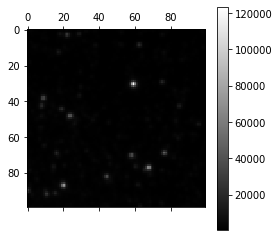

In [7]:
# the subimage of M2 considered in our paper
plt.matshow(sdss_image[0].cpu(), cmap = plt.cm.gray)
plt.colorbar()

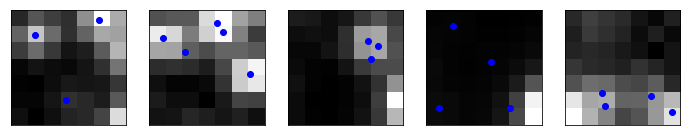

In [8]:
# a few example patches. 
# blue are hubble locations

f, axarr = plt.subplots(1, 5, figsize=(12, 6))

for i in range(5): 
    plotting_utils.plot_subimage(axarr[i], 
                                 sdss_image[0],
                                 None, 
                                 hubble_locs, 
                                 x0 = int(np.random.choice(100, 1)), 
                                 x1 = int(np.random.choice(100, 1)), 
                                 patch_slen = 7)
    axarr[i].set_xticks([]);
    axarr[i].set_yticks([]);
    


### 1. Load StarNet fits

In [9]:
# wake-sleep encoder
star_encoder_ws = starnet_lib.StarEncoder(slen = 100,
                                            ptile_slen = 8,
                                            step = 2,
                                            edge_padding = 3, 
                                            n_bands = 2,
                                            max_detections = 2)

star_encoder_ws.load_state_dict(torch.load('../fits/starnet-encoder-iter2', 
                               map_location=lambda storage, loc: storage))


star_encoder_ws.eval(); 
star_encoder_ws.to(device);

starnet_ws_map_locs, starnet_ws_map_fluxes, starnet_ws_map_n_stars = \
    star_encoder_ws.sample_star_encoder(sdss_image.unsqueeze(0).to(device), 
                                    return_map_n_stars = True, 
                                    return_map_star_params = True)[0:3]

# Sample from the posterior
n_starnet_samples = 1000
starnet_ws_locs, starnet_ws_fluxes, starnet_ws_map_n_stars = \
    star_encoder_ws.sample_star_encoder(sdss_image.unsqueeze(0).to(device), 
                                        n_samples=n_starnet_samples,
                                        return_map_n_stars = False, 
                                        return_map_star_params = False
                                       )[0:3]

In [153]:
x = starnet_ws_locs[0, :, 0].numpy()
x = x[x > 0]
x = np.sort(np.unique(x))

(981,)

### 2. Functions for Applying BLiP

In [10]:
def elapsed(time0):
    return np.around(time.time() - time0, 3)

In [70]:
def get_pips(locs, fluxes, scaled_log_fluxes, time0):
    """
    Get posterior inclusion probabilities. 

    Returns:
    pips : dict 
        Maps tuples of the form
            (x, y, lflux, rflux, gridsize, fluxgridsize)
        to the posterior inclusion probability.
        Note in the grid def, the grid is [x, x + delta] cross [y, y + delta]
        cross [lflux, lflux + fluxdelta] x [rflux, rflux + delta]
        where delta = 1 / gridsize
    """
    pips = dict()

    N = locs.shape[0]
    for j in range(N):
        # Get active fluxes and locations
        active = fluxes[j, :, 0] != 0
        lflux = scaled_log_fluxes[j, active, 0]
        rflux = scaled_log_fluxes[j, active, 1]
        xloc = locs[j, active, 0]
        yloc = locs[j, active, 1]

        # Complexity: O(len(deltas) * len(fluxd) * nactive)
        nactive = active.sum()
        for loc_grid_size in loc_grid_sizes:
            # Find centers
            xc = np.floor(xloc * loc_grid_size) / loc_grid_size
            yc = np.floor(yloc * loc_grid_size) / loc_grid_size
            for flux_grid_size in flux_grid_sizes:
                lc = np.floor(lflux * flux_grid_size) / flux_grid_size
                rc = np.floor(rflux * flux_grid_size) / flux_grid_size
                # Eliminate duplicates
                cent = list(set(tuple(d) for d in zip(xc, yc, lc, rc)))
                # Add one-by-one to pips: this is the bottleneck, could be cythonized
                for (x,y,l,r) in cent:
                    key = (x, y, l, r, loc_grid_size, flux_grid_size)
                    if key not in pips:
                        pips[key] = 1 / N
                    else:
                        pips[key] += 1 / N

        if j % 150 == 0:
            print(f"Finished with {j} / {N} iterations at time {elapsed(time0)}.")
            
    return pips
    
def calculate_overlaps(cent, radii):
    """
    cent : p-length array of centers of boxes
    radii : p-length array of radius of box
    """
    dists = np.abs(cent.reshape(-1, 1) - cent.reshape(1, -1))
    deltas = radii.reshape(-1, 1) + radii.reshape(1, -1)
    return dists < deltas

def construct_nodes(
    pips,
    time0,
    max_blip_size=1500,
    max_pep=0.25,
    slack=0.0
):
    """
    Constructs inputs to BLiP from PIPs
    """
    # Prefilter to exclude regions with PEPs > 0.25
    filtered_peps = {}
    for key in pips:
        pep = 1 - pips[key]
        if pep <= max_pep:
            filtered_peps[key] = pep
    
    ngroups = len(filtered_peps)
    if ngroups > 50000:
        raise ValueError(f"Computing adjacency matrix may be too inefficient for {ngroups} PEPs.")

    # Extract corners/centers of groups
    keys = sorted(filtered_peps.keys())
    xcorn = np.array([k[0] for k in keys])
    ycorn = np.array([k[1] for k in keys])
    loc_delta = np.array([1/k[4] for k in keys])
    xcent = xcorn + loc_delta / 2
    ycent = ycorn + loc_delta / 2
    # Repeat for fluxes
    lcorn = np.array([k[2] for k in keys])
    rcorn = np.array([k[3] for k in keys])
    flux_delta = np.array([1/k[5] for k in keys])
    lcent = lcorn + flux_delta / 2
    rcent = rcorn + flux_delta / 2
    # get peps
    peps_arr = np.array([filtered_peps[key] for key in keys])

    # Calculate distances between x and y
    print(f"Constructing constraint matrix with ngroups={ngroups} at {elapsed(time0)}")
    constraints = np.ones((ngroups, ngroups)).astype(bool)
    for cent, radii in zip(
        [xcent, ycent, lcent, rcent],
        [loc_delta / 2, loc_delta / 2, flux_delta / 2, flux_delta /2]
    ):
        overlap = calculate_overlaps(cent, radii)
        constraints = constraints & overlap
    
    # Split problem into connected components
    print(f"Isolating connected components at {elapsed(time0)}")
    G = nx.Graph(constraints)
    components = list(nx.algorithms.components.connected_components(G))
    merged_components = [[]]
    for c in components:
        if len(merged_components[-1]) + len(c) > max_blip_size:
            merged_components.append([])
        merged_components[-1].extend(list(c))
        
    # Construct nodes for BLiP
    all_nodes = []
    for component in merged_components:
        component_nodes = []
        for j in component:
            group = set(np.where(constraints[j])[0].tolist())
            component_nodes.append(
                hpt.trees.PvalDAGNode(
                    node_id=j,
                    data=dict(
                        group=group, 
                        pep=peps_arr[j], 
                        x=xcent[j], 
                        y=ycent[j],
                        loc_delta=loc_delta[j] / 2,
                        log_lflux=lcent[j],
                        log_rflux=rcent[j],
                        flux_delta=flux_delta[j] / 2,
                    )
                )
            )
        all_nodes.append(component_nodes)    
        
    # Utilities are proportional to area
    utilities = 1 / (((slack+flux_delta)**2) * ((slack+loc_delta)**2))
    utilities = utilities / utilities.mean()
    utilities *= (1 - peps_arr)
    
    return all_nodes, merged_components, utilities

In [71]:
# Run BLiP 
def apply_blip(all_nodes, components, utilities, q, max_pep, time0):
    # Run BLiP
    all_rej = []
    n_runs = len(all_nodes)
    for i, nodes, component in zip(range(n_runs), all_nodes, components):
        rej = hpt.blr.BLiP(
            nodes=nodes,
            utilities=utilities[component],
            q=q,
            max_pep=max_pep,
            perturb=False,
            error='fdr',
        )
        all_rej.extend(rej)
        
    print(f"Finished BLiP runs for q={q} at {elapsed(time0)}.")
    return all_rej

# Wrapper function to apply BLiP
def blip_pipeline(
    sampled_locs,
    sampled_fluxes,
    qs=[0.05, 0.1, 0.2, 0.35, 0.5],
    max_pep=0.5,
    **kwargs
):
    time0 = time.time()
    
    # convert to numpy
    locs = sampled_locs.numpy()
    fluxes = sampled_fluxes.numpy()
    # Convert fluxes to log scale
    raw_log_fluxes = np.log10(fluxes)
    max_log_flux = raw_log_fluxes.max()
    scaled_log_fluxes = raw_log_fluxes / max_log_flux

    # whether the location is active
    active = fluxes[:, :, 0] > 0
    locs[~active] = -1
    
    # Compute PIPs
    pips = get_pips(locs, fluxes, scaled_log_fluxes, time0=time0)
    
    # Construct nodes
    all_nodes, components, utilities = construct_nodes(
        pips, time0=time0, max_pep=max_pep, **kwargs
    )
    
    # Run BLiP
    blip_outputs = dict()
    for q in qs:
        blip_outputs[q] = apply_blip(
            all_nodes=all_nodes,
            utilities=utilities,
            components=components,
            q=q,
            max_pep=max_pep,
            time0=time0
        )
    
    return blip_outputs, dict(
        max_log_flux=max_log_flux,
        all_nodes=all_nodes,
        utilities=utilities,
        components=components,
        pips=pips
    )
    


## Performance evaluation

In [72]:
mag_vec = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

MAG_CONST = 2.5
def convert_nmgy_to_mag(nmgy):
    return 22.5 - MAG_CONST * np.log10(nmgy)

def filter_params(locs, fluxes, slen, pad = 5):
    """
    Remove sources too close to the border of the image.
    """
    assert len(locs.shape) == 2

    if fluxes is not None:
        assert len(fluxes.shape) == 1
        assert len(fluxes) == len(locs)

    _locs = locs * (slen - 1)
    which_params = (_locs[:, 0] > pad) & (_locs[:, 0] < (slen - pad)) & \
                        (_locs[:, 1] > pad) & (_locs[:, 1] < (slen - pad))

    if fluxes is not None:
        return locs[which_params], fluxes[which_params], which_params
    else:
        return locs[which_params], None, which_params

def get_locs_error(locs, true_locs):
    """
    Parameters
    ----------
    locs : (n, 2) shaped array of estimated locations
    true_locs : (m, 2) shaped array of true locations
    
    Returns
    -------
    (m, n)-shaped array of taxicab distance between
    each estimated location and the true location.
    """
    n = locs.shape[0]
    return np.abs(
        locs.reshape(1, -1, 2) - true_locs.reshape(-1, 1, 2)
    ).max(axis=2)


def get_mag_error(mags, true_mags):
    """
    Parameters
    ----------
    mags : (n,) shaped array of estimated magnitudes
    true_locs : (m,) shaped array of true magnitudes
    
    Returns
    -------
    (m, n)-shaped array of abs distance between log mags
    and log true mags.
    """
    return np.abs(
        mags.reshape(1, -1) - \
        true_mags.reshape(-1, 1)
    )

def get_summary_stats(
    est_locs,
    true_locs,
    loc_errors,
    slen,
    est_fluxes,
    true_fluxes,
    flux_errors,
    nelec_per_nmgy,
    pad = 5,
    slack = 0.5
):
    """
    Parameters
    ----------
    loc_errors : np.ndarray
        (n,)-length array of radii of bounding boxes for locations
    flux_errors : np.ndarray
        (n,)-length array of radii of bounding interval (in log space)
        for fluxes.
    slen : int
        number of pixels in the (square) image
    pad : int 
        number of pixels of border to exclude
    slack : float
        expected amount of distance (in pixels) between
        true and estimated sources due to differences
        in imaging.
    """

    # remove border
    est_locs, est_fluxes, which_params = filter_params(
        est_locs, 
        est_fluxes, 
        slen,
        pad
    )
    loc_errors = loc_errors[which_params]
    flux_errors = flux_errors[which_params]
    
    true_locs, true_fluxes, _ = filter_params(
        true_locs,
        true_fluxes,
        slen,
        pad
    )

    if (est_fluxes is None) or (true_fluxes is None):
        mag_error = 0.
    else:
        # convert to magnitude
        est_mags = convert_nmgy_to_mag(est_fluxes / nelec_per_nmgy)
        true_mags = convert_nmgy_to_mag(true_fluxes / nelec_per_nmgy)
        mag_error = get_mag_error(est_mags, true_mags)


    # location errors
    locs_error = get_locs_error(est_locs * (slen - 1), true_locs * (slen - 1))
    locs_error_tol = slack + (slen - 1) * loc_errors.reshape(1, -1)
    locs_flags = (locs_error < locs_error_tol)
    
    # mag errors
    mags_error_tol = slack + MAG_CONST * flux_errors.reshape(1, -1)
    mags_flags = (mag_error < mags_error_tol)

    
    # array : for each true source, is there a matching estimated source
    tpr_bool = np.any(locs_flags * mags_flags, axis=1)
    
    # array: for each estimated source, is there a matching true source
    ppv_bool = np.any(locs_flags * mags_flags, axis=0)

    return tpr_bool, ppv_bool, which_params


# def get_summary_statistics(est_locs, est_fluxes): 
    
#     # get tpr and ppv as function of magnitude
#     tpr_vec = image_statistics_lib.get_tpr_vec(est_locs,
#                                                hubble_locs, 
#                                                sdss_image.shape[-1], # slen
#                                                est_fluxes, 
#                                                hubble_fluxes[:, 0],
#                                                nelec_per_nmgy, 
#                                                mag_vec = mag_vec)[0]
    
#     ppv_vec = image_statistics_lib.get_ppv_vec(est_locs,
#                                                hubble_locs, 
#                                                sdss_image.shape[-1], 
#                                                est_fluxes, 
#                                                hubble_fluxes[:, 0],
#                                                nelec_per_nmgy, 
#                                                mag_vec = mag_vec)[0]
    
#     # get overal tpr and ppv    
#     tpr, ppv = \
#         image_statistics_lib.get_summary_stats(est_locs,
#                                                hubble_locs, 
#                                                sdss_image.shape[-1], 
#                                                est_fluxes, 
#                                                hubble_fluxes[:, 0],
#                                                nelec_per_nmgy)[0:2]
#     # f1 score 
#     f1 = 2 * (tpr * ppv) / (tpr + ppv)
#     return tpr, ppv, f1, tpr_vec, ppv_vec

In [73]:
hub_loc = hubble_locs.numpy()
hub_flux = hubble_fluxes[:, 0].numpy()

def catalogue_power_fdr_area(all_locs, all_fluxes, pad=5, slack=0.1):
    """
    all_locs : 3d array, (nsamples x nstars x 2)
    all_fluxes: 2d array (nsamples x nstars)
    """
    
    N = all_locs.shape[0]
    tpr = 0
    ppv = 0
    area = 0
    for n in range(N):
    
        # ignore inactive points
        fluxes = all_fluxes[n]
        active = fluxes[n] > 0
        locs = all_locs[n][active].reshape(-1, 2)
        fluxes = fluxes[active].reshape(-1)
        
        # area
        area_n = locs.shape[0] * (0.5 / 100)**2 # a bit naive

        # errors are just zero
        errors = np.zeros(locs.shape[0])

        # Compute power/FDR
        tpr_bool, ppv_bool, which_est = get_summary_stats(
            est_locs=locs, 
            true_locs=hub_loc,
            loc_errors=errors,
            est_fluxes=fluxes,
            true_fluxes=hub_flux,
            flux_errors=errors,
            nelec_per_nmgy=nelec_per_nmgy,
            slen=100,
            pad=pad,
            slack=slack
        )
        tpr += tpr_bool.mean() / N
        ppv += ppv_bool.mean() / N
        area += area_n / N
    
    return tpr, 1 - ppv, area

def blip_rej_to_numpy(blip_rej, max_log_flux):
    
    # Turn output into numpy arrays
    xrej = [node.data['x'] for node in blip_rej]
    yrej = [node.data['y'] for node in blip_rej]
    loc_errors = np.array([node.data['loc_delta'] for node in blip_rej])
    lrej = [node.data['log_lflux'] for node in blip_rej]
    rrej = [node.data['log_rflux'] for node in blip_rej]
    flux_errors = np.array([node.data['flux_delta'] for node in blip_rej])
    loc_rej = np.stack([xrej, yrej], axis=1)
    flux_rej = 10**(max_log_flux * np.array(lrej)) # doesn't include rrej
    
    return xrej, yrej, loc_errors, lrej, rrej, flux_errors, loc_rej, flux_rej

def blip_power_fdr_area(all_rej, max_log_flux, pad=5, noflux=True, slack=0.0):
    
    # Convert to numpy
    xrej, yrej, loc_errors,\
    lrej, rrej, flux_errors, loc_rej, flux_rej = blip_rej_to_numpy(
        all_rej, max_log_flux
    )
    
    if noflux:
        flux_rej = None
    
    # Compute power/FDR
    tpr_bool, ppv_bool, which_est = get_summary_stats(
        est_locs=loc_rej, 
        true_locs=hub_loc,
        loc_errors=loc_errors,
        est_fluxes=flux_rej,
        true_fluxes=hub_flux,
        flux_errors=flux_errors,
        nelec_per_nmgy=nelec_per_nmgy,
        slen=100,
        pad=pad,
        slack=slack
    )
    
    # Area
    area = 0
    for node in all_rej:
        area += (node.data['loc_delta'] + 0.5 / 100)**2
    
    return tpr_bool.mean(), 1 - ppv_bool.mean(), area, tpr_bool, ppv_bool


## Analysis, start to finish

In [74]:
loc_grid_sizes

array([   50.,    62.,    78.,    97.,   121.,   151.,   188.,   234.,
         292.,   365.,   455.,   567.,   707.,   882.,  1100.,  1371.,
        1710.,  2132.,  2659.,  3316.,  4135.,  5157.,  6431.,  8019.,
       10000.])

In [75]:
# Radii for epsilon-balls around deltas, fluxes.
# These are globals.
loc_grid_sizes = np.around(np.logspace(np.log10(50), 4, 25))
flux_grid_sizes = [1] # for now, no flux calculations

In [76]:
# Run BLiP on starnet
starnet_blip_out, meta_starnet = blip_pipeline(
    starnet_ws_locs, starnet_ws_fluxes, max_pep=0.5
)

/tmp/ipykernel_15856/906142483.py:34: RuntimeWarning: divide by zero encountered in log10


Finished with 0 / 1000 iterations at time 0.061.
Finished with 150 / 1000 iterations at time 4.707.
Finished with 300 / 1000 iterations at time 9.967.
Finished with 450 / 1000 iterations at time 15.293.
Finished with 600 / 1000 iterations at time 20.774.
Finished with 750 / 1000 iterations at time 26.421.
Finished with 900 / 1000 iterations at time 31.777.
Constructing constraint matrix with ngroups=4550 at 38.002
Isolating connected components at 38.437
BLiP problem has 1491 groups in contention, with 1491 active features
BLiP problem has 1396 groups in contention, with 1396 active features
BLiP problem has 1388 groups in contention, with 1388 active features
BLiP problem has 275 groups in contention, with 275 active features
Finished BLiP runs for q=0.05 at 47.14.
BLiP problem has 1491 groups in contention, with 1491 active features
BLiP problem has 1396 groups in contention, with 1396 active features
BLiP problem has 1388 groups in contention, with 1388 active features
BLiP problem 

In [131]:
# Power evaluations
mlf = meta_starnet['max_log_flux']
qs = []
methods = []
slacks = []
naive_powers = []
powers = []
fdrs = []
areas = []
for method, blip_out in zip(
    ['Starnet'], 
    [starnet_blip_out, ],#pcat_blip_out],
):
    for slack in [0.0, 0.05, 0.1, 0.5]:
        for q in blip_out.keys():
            blip_rej = blip_out[q]
            power, fdr, area, tpr_bool, ppv_bool = blip_power_fdr_area(blip_rej, mlf, slack=slack)
            qs.append(q)
            methods.append(method)
            naive_powers.append(power)
            powers.append(ppv_bool.sum() / tpr_bool.shape[0])
            fdrs.append(fdr)
            areas.append(area)
            slacks.append(slack)
    
blip_eval_df = pd.DataFrame()
blip_eval_df['Naive Power'] = naive_powers
blip_eval_df['Power'] = powers
blip_eval_df['FDR'] = fdrs
#blip_eval_df['Total Area'] = areas
blip_eval_df['Slack (pixels)'] = slacks
blip_eval_df['method'] = methods
blip_eval_df['method'] += ' + BLiP'
blip_eval_df['Nominal Level'] = qs

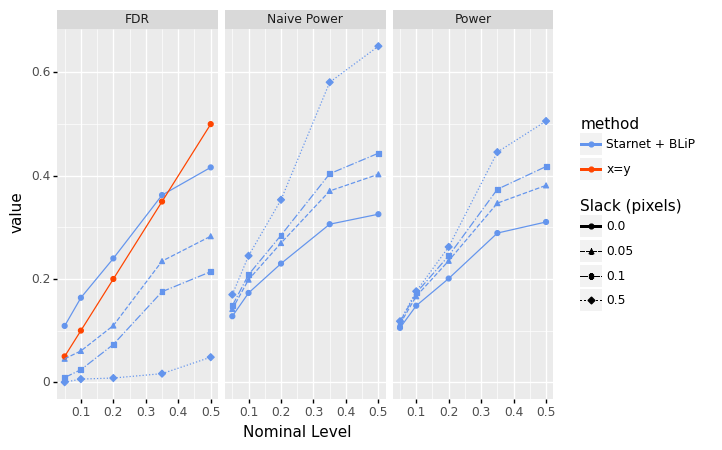

In [132]:
from plotnine import *
melted_bdf = blip_eval_df.melt(id_vars=[
    'Nominal Level', 'method', 'Slack (pixels)'
], var_name=['measurement'])
qlines = melted_bdf.loc[
    (melted_bdf['measurement'] == 'FDR')
    & (melted_bdf['method'] == 'Starnet + BLiP')
    & (melted_bdf['Slack (pixels)'] == 0.0)
].copy()
qlines['method'] = 'x=y'
qlines['value'] = qlines['Nominal Level']
melted_bdf = pd.concat([melted_bdf, qlines], axis='index')
melted_bdf['Slack (pixels)'] = np.around(melted_bdf['Slack (pixels)'], 2).astype(str)


g = (
        ggplot(
        melted_bdf,
        aes(
            x='Nominal Level',
            y='value',
            color='method',
            shape='Slack (pixels)',
            linetype='Slack (pixels)'
        )
    ) + 
    geom_point() +
    geom_line() + 
    facet_grid("~measurement") +
    scale_color_manual(['cornflowerblue', 'orangered', 'forestgreen', 'black'])
)
print(g)
#g.save("../../../blip_qcurves_v2.png")

### 5. Evaluate performance of BLiP

In [81]:
def get_flags(locs, lmv, umv):
    flags = (locs[:, 0] > lmv) & (locs[:, 0] < umv)
    return flags & (locs[:, 1] > lmv) & (locs[:, 1] < umv)

def create_preplot_df(
    locs, 
    lmv, 
    umv,
    method,
    loc_errors = None,
    hubble=False,
    slack=0.0
):
    df = pd.DataFrame(locs, columns=['x', 'y'])
    if loc_errors is None:
        loc_errors = np.zeros(df.shape[0])
    df['loc_errors'] = loc_errors
    
    df['xmin'] = df['x'] - df['loc_errors']
    df['xmax'] = df['x'] + df['loc_errors']
    df['ymin'] = df['y'] - df['loc_errors'] 
    df['ymax'] = df['y'] + df['loc_errors']
    
    df['in_subregion'] = get_flags(locs, lmv, umv)
    
    # Bool of whether it's a true discovery
    if not hubble:
        tpr_bool, ppv_bool, which_est = get_summary_stats(
            est_locs=locs, 
            true_locs=hub_loc,
            loc_errors=loc_errors,
            est_fluxes=None,
            true_fluxes=None,
            flux_errors=loc_errors,
            nelec_per_nmgy=nelec_per_nmgy,
            slen=100,
            pad=0,
            slack=slack
        )
        # Label true/false discoveries
        df['true_disc'] = ppv_bool
    else:
        df['true_disc'] = False
    df['method'] = method
    df['method2'] = method
    return df


In [82]:
lmv = 0.2
umv = 0.35
slocs = starnet_ws_map_locs.numpy()[0, :, :]
sdf = create_preplot_df(slocs, lmv=lmv, umv=umv, method='Starnet', slack=0.5)
all_dfs = [sdf]
for q in starnet_blip_out.keys():
    sblip_np = blip_rej_to_numpy(starnet_blip_out[q], meta_starnet['max_log_flux'])
    _, _, sb_loc_err, _, _, sb_flux_err, sblocs, sbflux = sblip_np
    sbdf = create_preplot_df(
        sblocs,
        lmv=lmv,
        umv=umv,
        loc_errors=sb_loc_err,
        method=f'Starnet + BLiP (q={q})'
    )
    all_dfs.append(sbdf)

In [83]:
hdf = create_preplot_df(
    hub_loc, lmv=lmv, umv=umv, method='Hubble', hubble=True
)
for method in [df['method'].unique()[0] for df in all_dfs]:
    hdf2 = hdf.copy()
    hdf2['method2'] = method
    all_dfs.append(hdf2)


full_df = pd.concat(all_dfs, axis='index')
full_df['color'] = full_df['true_disc'].astype(str)
full_df.loc[full_df['method'] == 'Hubble', 'color'] = 'Hubble'

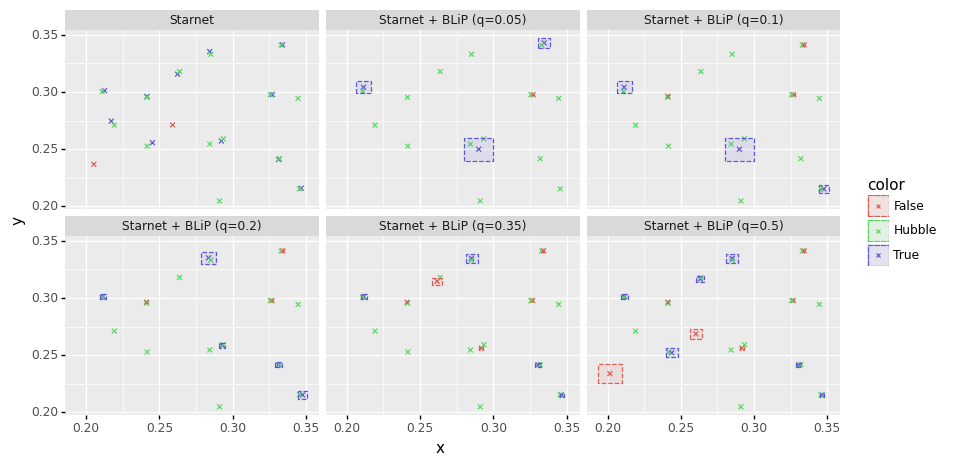

<ggplot: (8783675390458)>

In [84]:
from plotnine import *
g = (
    ggplot(full_df.loc[full_df['in_subregion']], aes(
        x='x',
        y='y',
        color='color',
        fill='color'
    )) +
    geom_point(alpha=1, shape='x') +
    geom_rect(
        aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax'),
        alpha=0.1,
        linetype='dashed'
    ) +
    theme(figure_size=(10,5)) +
    facet_wrap('~method2')
)
g


In [66]:
outputs = starnet_blip_out[0.5]
x = [node.data['x'] for node in outputs]
y = [node.data['y'] for node in outputs]
delta = [node.data['loc_delta'] for node in outputs]
for x, 

[0.0007062146892655367,
 0.005154639175257732,
 0.005154639175257732,
 0.008064516129032258,
 0.0007062146892655367,
 0.00641025641025641,
 0.0033112582781456954,
 0.0008802816901408451,
 0.0033112582781456954,
 0.0033112582781456954,
 0.008064516129032258,
 0.0013698630136986301,
 0.001098901098901099,
 0.0026595744680851063,
 0.005154639175257732,
 0.002127659574468085,
 0.0033112582781456954,
 0.0017064846416382253,
 0.005154639175257732,
 0.0033112582781456954,
 0.0013698630136986301,
 0.0008802816901408451,
 0.0026595744680851063,
 0.0033112582781456954,
 0.001098901098901099,
 0.008064516129032258,
 0.0013698630136986301,
 0.0026595744680851063,
 0.0033112582781456954,
 0.001098901098901099,
 0.0026595744680851063,
 0.004132231404958678,
 0.001098901098901099,
 0.002127659574468085,
 0.004132231404958678,
 0.0013698630136986301,
 0.004132231404958678,
 0.002127659574468085,
 0.004132231404958678,
 0.004132231404958678,
 0.0002922267679719462,
 0.004132231404958678,
 0.00212765957

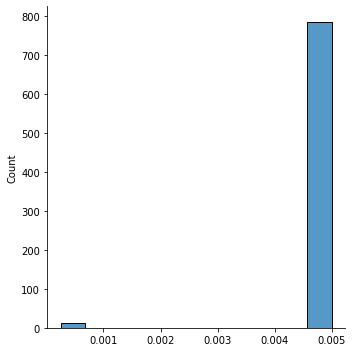

In [426]:
import seaborn as sns
sns.displot(sb_loc_err)

## Below this is old

## Below this is old

## Below this is old

## Below this is old

## Below this is old

## Below this is old

## Below this is old

ValueError: Unrecognized marker style ['.', '.', ',', '.', ',', '.']

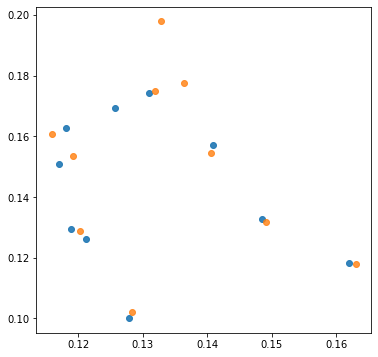

In [217]:
import matplotlib.patches as patch





hflag = get_flags(hub_loc, lmv, umv)
sflag = get_flags(slocs, lmv, umv)
sbflag = get_flags(sblocs, lmv, umv)

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(
    hub_loc[:, 0][hflag], 
    hub_loc[:, 1][hflag],
    label='Hubble',
    alpha=0.9
)
ax.scatter(
    slocs[:, 0][sflag], slocs[:, 1][sflag],label='Starnet', alpha=0.8
)
ax.scatter(
    sblocs[:, 0][sbflag], sblocs[:, 1][sbflag], label='Starnet + BLiP', alpha=0.8,
    marker=['.' if j else ',' for j in bstar_ppv_bool[sbflag]]
)
for j in range(sblocs.shape[0]):
    if sbflag[j]:
        err = sb_loc_err[j]
        x = sblocs[j, 0]
        y = sblocs[j, 1]
        ax.add_patch(
            patch.Rectangle(
                (x - err/2, y-err/2,), err, err, facecolor='green', alpha=0.5
            ),
        )

ax.legend()
plt.show()

### Naive baseline

In [95]:
catalogue_power_fdr_area(
    pcat_sampled_locs.numpy(),
    pcat_sampled_fluxes[:, :, 0].numpy()
)
# pcat_power += power
# pcat_fdr += fdr
# pcat_area += area

# pcat_power /= N
# pcat_fdr /= N
# pcat_area /= N
# print(pcat_power, pcat_fdr, pcat_area)

(0.5590655209452204, 0.5954452963062008, 0.05000000000000021)

In [217]:
catalogue_power_fdr_area(
    starnet_map_locs[0].numpy(), 
    starnet_map_fluxes[0, :, 0].numpy()
)

(0.7185821697099892, 0.3771593090211133, 0.028550000000000002)

### 4. Run BLiP

In [19]:
blip_dir = os.path.split(os.path.split(package_dir)[0])[0] + "/hpt/"
sys.path.insert(0, blip_dir)
import hpt

In [20]:
def elapsed(time0):
    return np.around(time.time() - time0, 3)

In [21]:
# convert to numpy
locs = pcat_sampled_locs.numpy()
fluxes = pcat_sampled_fluxes.numpy()
raw_log_fluxes = np.log10(fluxes)
max_log_flux = raw_log_fluxes.max()
scaled_log_fluxes = raw_log_fluxes / max_log_flux

hub_loc = hubble_locs.numpy()
hub_flux = hubble_fluxes[:, 0].numpy()


# whether the location is active
active = fluxes[:, :, 0] > 0
locs[~active] = -1
N = locs.shape[0]

/tmp/ipykernel_13109/90078424.py:4: RuntimeWarning: divide by zero encountered in log10
  raw_log_fluxes = np.log10(fluxes)


In [23]:
# dict --> dict --> float in [0,1]
# (x, y, lflux, rflux, gridsize, fluxgridsize) : PIP
# note in the grid def, the grid is [x, x + delta] cross [y, y + delta]
# cross [lflux, lflux + fluxdelta] x [rflux, rflux + delta]
# where delta = 1 / gridsize

ptime0 = time.time()
pips = dict()

for j in range(N):
    # Get active fluxes and locations
    active = fluxes[j, :, 0] != 0
    lflux = scaled_log_fluxes[j, active, 0]
    rflux = scaled_log_fluxes[j, active, 1]
    xloc = locs[j, active, 0]
    yloc = locs[j, active, 1]
    
    # Complexity: O(len(deltas) * len(fluxd) * nactive)
    nactive = active.sum()
    for loc_grid_size in loc_grid_sizes:
        # Find centers
        xc = np.floor(xloc * loc_grid_size) / loc_grid_size
        yc = np.floor(yloc * loc_grid_size) / loc_grid_size
        for flux_grid_size in flux_grid_sizes:
            lc = np.floor(lflux * flux_grid_size) / flux_grid_size
            rc = np.floor(rflux * flux_grid_size) / flux_grid_size
            # Eliminate duplicates
            cent = list(set(tuple(d) for d in zip(xc, yc, lc, rc)))
            # Add one-by-one to pips: this is the bottleneck, should be cythonized
            for (x,y,l,r) in cent:
                key = (x, y, l, r, loc_grid_size, flux_grid_size)
                if key not in pips:
                    pips[key] = 1 / N
                else:
                    pips[key] += 1 / N
        
        
    if j % 25 == 0:
        print(f"Finished with {j} / {N} iterations at time {elapsed(ptime0)}.")
    

Finished with 0 / 300 iterations at time 0.067.
Finished with 25 / 300 iterations at time 2.134.
Finished with 50 / 300 iterations at time 4.321.
Finished with 75 / 300 iterations at time 6.531.
Finished with 100 / 300 iterations at time 8.756.
Finished with 125 / 300 iterations at time 11.266.
Finished with 150 / 300 iterations at time 13.747.
Finished with 175 / 300 iterations at time 16.267.
Finished with 200 / 300 iterations at time 18.717.
Finished with 225 / 300 iterations at time 21.239.
Finished with 250 / 300 iterations at time 23.751.
Finished with 275 / 300 iterations at time 26.333.


In [24]:
# Prefilter to exclude regions with PEPs > 0.25
max_pep = 0.25
filtered_peps = {}
for key in pips:
    pip = pips[key]
    if pip > 0.75:
        filtered_peps[key] = 1 - pips[key]

In [67]:
def calculate_overlaps(cent, radii):
    """
    cent : p-length array of centers of boxes
    radii : p-length array of radius of box
    """
    dists = np.abs(cent.reshape(-1, 1) - cent.reshape(1, -1))
    deltas = np.maximum(radii.reshape(-1, 1) + radii.reshape(1, -1))
    return dists < deltas

In [68]:
# Construct PEP nodes
ngroups = len(filtered_peps)
if ngroups > 50000:
    raise ValueError(f"Computing adjacency matrix may be too inefficient for this many PIPs.")

# Extract corners/centers of groups
keys = sorted(filtered_peps.keys())
xcorn = np.array([k[0] for k in keys])
ycorn = np.array([k[1] for k in keys])
loc_delta = np.array([1/k[4] for k in keys])
xcent = xcorn + loc_delta / 2
ycent = ycorn + loc_delta / 2
# Repeat for fluxes
lcorn = np.array([k[2] for k in keys])
rcorn = np.array([k[3] for k in keys])
flux_delta = np.array([1/k[5] for k in keys])
lcent = lcorn + flux_delta / 2
rcent = rcorn + flux_delta / 2
# get peps
peps_arr = np.array([filtered_peps[key] for key in keys])

# Calculate distances between x and y
constraints = np.ones((ngroups, ngroups)).astype(bool)
for cent, radii in zip(
    [xcent, ycent, lcent, rcent],
    [loc_delta / 2, loc_delta / 2, flux_delta / 2, flux_delta /2]
):
    overlap = calculate_overlaps(cent, radii)
    constraints = constraints & overlap

NameError: name 'filtered_peps' is not defined

In [69]:
# Split problem into connected components
G = nx.Graph(constraints)

NameError: name 'constraints' is not defined

In [28]:
components = list(nx.algorithms.components.connected_components(G))
max_size = 1500
merged_components = [[]]
for c in components:
    if len(merged_components[-1]) + len(c) > max_size:
        merged_components.append([])
    merged_components[-1].extend(list(c))

In [29]:
# Utilities are proportional to area
utilities = 1 / ((flux_delta**2) * (loc_delta**2))
utilities = utilities / utilities.mean()
utilities *= (1 - peps_arr)

In [30]:
btime = time.time()
all_rej = []
for component in merged_components:
    nodes = []
    for j in component:
        group = set(np.where(constraints[j])[0].tolist())
        nodes.append(
            hpt.trees.PvalDAGNode(
                node_id=j,
                data=dict(
                    group=group, 
                    pep=peps_arr[j], 
                    x=xcent[j], 
                    y=ycent[j],
                    loc_delta=loc_delta[j] / 2,
                    log_lflux=lcent[j],
                    log_rflux=rcent[j],
                    flux_delta=flux_delta[j] / 2,
                )
            )
        )
    rej = hpt.blr.BLiP(
        nodes=nodes,
        utilities=utilities,
        q=0.05,
        max_pep=0.25,
        perturb=False,
        error='fdr',
    )
    all_rej.extend(rej)
    print(f"Time = {elapsed(btime)}")

BLiP problem has 1494 groups in contention, with 1494 active features
Time = 1.463
BLiP problem has 1500 groups in contention, with 1500 active features
Time = 3.81
BLiP problem has 1498 groups in contention, with 1498 active features
Time = 6.573
BLiP problem has 1498 groups in contention, with 1498 active features
Time = 9.855
BLiP problem has 1490 groups in contention, with 1490 active features
Time = 14.155
BLiP problem has 1498 groups in contention, with 1498 active features
Time = 19.083
BLiP problem has 1499 groups in contention, with 1499 active features
Time = 24.25
BLiP problem has 1492 groups in contention, with 1492 active features
Time = 30.528
BLiP problem has 476 groups in contention, with 476 active features
Time = 35.818


In [32]:
# extract output
xrej = [node.data['x'] for node in all_rej]
yrej = [node.data['y'] for node in all_rej]
loc_errors = np.array([node.data['loc_delta'] for node in all_rej])
lrej = [node.data['log_lflux'] for node in all_rej]
rrej = [node.data['log_rflux'] for node in all_rej]
flux_errors = np.array([node.data['flux_delta'] for node in all_rej])
loc_rej = np.stack([xrej, yrej], axis=1)
flux_rej = 10**(max_log_flux * np.array(lrej)) # doesn't include rrej

### 5. Performance metrics

In [78]:
mag_vec = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

MAG_CONST = 2.5
def convert_nmgy_to_mag(nmgy):
    return 22.5 - MAG_CONST * np.log10(nmgy)

def filter_params(locs, fluxes, slen, pad = 5):
    """
    Remove sources too close to the border of the image.
    """
    assert len(locs.shape) == 2

    if fluxes is not None:
        assert len(fluxes.shape) == 1
        assert len(fluxes) == len(locs)

    _locs = locs * (slen - 1)
    which_params = (_locs[:, 0] > pad) & (_locs[:, 0] < (slen - pad)) & \
                        (_locs[:, 1] > pad) & (_locs[:, 1] < (slen - pad))

    if fluxes is not None:
        return locs[which_params], fluxes[which_params], which_params
    else:
        return locs[which_params], None, which_params

def get_locs_error(locs, true_locs):
    """
    Parameters
    ----------
    locs : (n, 2) shaped array of estimated locations
    true_locs : (m, 2) shaped array of true locations
    
    Returns
    -------
    (m, n)-shaped array of taxicab distance between
    each estimated location and the true location.
    """
    n = locs.shape[0]
    return np.abs(
        locs.reshape(1, -1, 2) - true_locs.reshape(-1, 1, 2)
    ).max(axis=2)


def get_mag_error(mags, true_mags):
    """
    Parameters
    ----------
    mags : (n,) shaped array of estimated magnitudes
    true_locs : (m,) shaped array of true magnitudes
    
    Returns
    -------
    (m, n)-shaped array of abs distance between log mags
    and log true mags.
    """
    return np.abs(
        np.log10(mags).reshape(1, -1) - \
        np.log10(true_mags).reshape(-1, 1)
    )

def get_summary_stats(
    est_locs,
    true_locs,
    loc_errors,
    slen,
    est_fluxes,
    true_fluxes,
    flux_errors,
    nelec_per_nmgy,
    pad = 5,
    slack = 0.5
):
    """
    Parameters
    ----------
    loc_errors : np.ndarray
        (n,)-length array of radii of bounding boxes for locations
    flux_errors : np.ndarray
        (n,)-length array of radii of bounding interval (in log space)
        for fluxes.
    slen : int
        number of pixels in the (square) image
    pad : int 
        number of pixels of border to exclude
    slack : float
        expected amount of distance (in pixels) between
        true and estimated sources due to differences
        in imaging.
    """

    # remove border
    est_locs, est_fluxes, which_params = filter_params(
        est_locs, 
        est_fluxes, 
        slen,
        pad
    )
    print(est_locs[0:1], est_locs.shape)
    print(est_fluxes[0:1], est_fluxes.shape)
    loc_errors = loc_errors[which_params]
    flux_errors = flux_errors[which_params]
    
    true_locs, true_fluxes, _ = filter_params(
        true_locs,
        true_fluxes,
        slen,
        pad
    )

    if (est_fluxes is None) or (true_fluxes is None):
        mag_error = 0.
    else:
        # convert to magnitude
        est_mags = convert_nmgy_to_mag(est_fluxes / nelec_per_nmgy)
        true_mags = convert_nmgy_to_mag(true_fluxes / nelec_per_nmgy)
        mag_error = get_mag_error(est_mags, true_mags)

    # location errors
    locs_error = get_locs_error(est_locs * (slen - 1), true_locs * (slen - 1))
    locs_error_tol = slack + (slen - 1) * loc_errors.reshape(1, -1)
    locs_flags = (locs_error < locs_error_tol)
    
    # mag errors
    mags_error_tol = slack + MAG_CONST * flux_errors.reshape(1, -1)
    mags_flags = (mag_error < mags_error_tol)

    
    # array : for each true source, is there a matching estimated source
    tpr_bool = np.any(locs_flags * mags_flags, axis=1)
    
    # array: for each estimated source, is there a matching true source
    ppv_bool = np.any(locs_flags * mags_flags, axis=0)

    return tpr_bool, ppv_bool, which_params


def get_summary_statistics(est_locs, est_fluxes): 
    
    # get tpr and ppv as function of magnitude
    tpr_vec = image_statistics_lib.get_tpr_vec(est_locs,
                                               hubble_locs, 
                                               sdss_image.shape[-1], # slen
                                               est_fluxes, 
                                               hubble_fluxes[:, 0],
                                               nelec_per_nmgy, 
                                               mag_vec = mag_vec)[0]
    
    ppv_vec = image_statistics_lib.get_ppv_vec(est_locs,
                                               hubble_locs, 
                                               sdss_image.shape[-1], 
                                               est_fluxes, 
                                               hubble_fluxes[:, 0],
                                               nelec_per_nmgy, 
                                               mag_vec = mag_vec)[0]
    
    # get overal tpr and ppv    
    tpr, ppv = \
        image_statistics_lib.get_summary_stats(est_locs,
                                               hubble_locs, 
                                               sdss_image.shape[-1], 
                                               est_fluxes, 
                                               hubble_fluxes[:, 0],
                                               nelec_per_nmgy)[0:2]
    # f1 score 
    f1 = 2 * (tpr * ppv) / (tpr + ppv)
    return tpr, ppv, f1, tpr_vec, ppv_vec

# Old

In [96]:
import time
import seaborn as sns

time0 = time.time()
def elapsed(time0):
    return np.around(time.time() - time0, 3)

def get_centers(xlocs, ylocs, flux1, flux2, sigfig=4):
    """
    Find 
    
    Note locs should be pre-flattened
    """
    xcent = np.around(xlocs, sigfig)
    ycent = np.around(ylocs, sigfig)
    f1cent = np.around(np.log(flux1), 1)
    f2cent = np.around(np.log(flux2), 1)
    cent = set(tuple(d) for d in zip(xcent, ycent, f1cent, f2cent)) 
    return np.array(list(cent))

cent = get_centers(
    xlocs=locs[:, :, 0][active].flatten(),
    ylocs=locs[:, :, 1][active].flatten(),
    flux1=fluxes[:, :, 0][active].flatten(),
    flux2=fluxes[:, :, 1][active].flatten(),
    sigfig=4
).astype(np.float32)

In [ ]:
# Creating this graph is very memory expensive
# note to self: this could be made cheaper by making the initial number of centers smaller and then
# defining the components as disjoint rectangles somehow
xcdists = np.abs(cent[:, 0].reshape(-1, 1) - cent[:, 0].reshape(1, -1))
ycdists = np.abs(cent[:, 1].reshape(-1, 1) - cent[:, 1].reshape(1, -1))

In [ ]:
import networkx as nx
G = nx.Graph((xcdists < max(DELTAS)) & (ycdists < max(DELTAS)))

In [ ]:
components = list(nx.algorithms.components.connected_components(G))
max_size = 1500
merged_components = [[]]
for c in components:
    if len(merged_components[-1]) + len(c) > max_size:
        merged_components.append([])
    merged_components[-1].extend(list(c))

### 4.1 New methods for getting PEPs

### 4.2 Old methods for getting PEPs

In [52]:
components = list(nx.algorithms.components.connected_components(G))
max_size = 1500
merged_components = [[]]
for c in components:
    if len(merged_components[-1]) + len(c) > max_size:
        merged_components.append([])
    merged_components[-1].extend(list(c))

In [56]:
# Okay, note to self
# It's possible we should do this in cython and not vectorize it as much idk
# need to think about this, is tricky
# If we just look at one center (x,y) it's easy to get 1 flux radius estimate in O(nradii * nsamples)
# so overall complexity O(nradii * nsamples)
# Fast fourier transform??

In [55]:
# Loop through and create PEPs
ctime = time.time()
for component in merged_components:
    comp_cent = cent[component]
    # Could subset this array and make it not contiguous later for speed
    xdists = np.abs(
        locs[:, :, 0].reshape(N, -1, 1) - comp_cent[:, 0].reshape(1, 1, -1)
    )
    ydists = np.abs(
        locs[:, :, 1].reshape(N, -1, 1) - comp_cent[:, 1].reshape(1, 1, -1)
    )
    print(xdists.shape, ydists.shape)
    print(f"Finished with component at {elapsed(ctime)}.")
    break

(300, 2000, 1475) (300, 2000, 1475)
Finished with component at 3.081.


In [32]:
# max_pep = 0.25

# # Compute PEPs for blocks of centers
# time0 = time.time()

# print(f"Computing PEPs for block 1 at {elapsed(time0)}")
# ncent = cent.shape[0]
# bstart = 0
# bsize = 1000
# xlocs = locs[:, :, 0].reshape(N, -1, 1).astype(np.float32)
# ylocs = locs[:, max_log_flux:, 1].reshape(N, -1, 1).astype(np.float32)
# xcent = cent[:, 0].reshape(1, 1, -1).astype(np.float32)
# ycent = cent[:, 1].reshape(1, 1, -1).astype(np.float32)
# while bstart < ncent:
#     # Calculate distances (expensive)
#     bend = min(bstart + bsize, ncent)
#     xdist = np.abs(xlocs - xcent[0, 0, bstart:bend])
#     xdmin = np.min(xdist, axis=1)
#     ydist = np.abs(ylocs - ycent[0, 0, bstart:bend].reshape(1,1,-1))
#     ydmin = np.min(ydist, axis=1)

#     # Compute PEPs at various threshholds
#     for delta in DELTAS:
#         included = (xdmin < delta) & (ydmin < delta)
#         delta_peps = 1 - included.mean(axis=1)
#         flags = delta_peps <= max_pep
#         for j in range(delta_peps.shape[0]):
#             if flags[j]:
#                 all_peps[tuple(cent[bstart + j])][delta] = delta_peps[j]

#     print(f"Finished block {bstart} / {ncent} at {elapsed(time0)}")
    
#     # update bstart
#     bstart = min(bstart + bsize, ncent)

In [31]:
# # Cache peps which take ~3 minutes to compute
# with open("all_peps.json", "w") as thefile:
#     thefile.write(json.dumps({str(k):v for k, v in all_peps.items()}))

In [33]:
# load cached peps
from ast import literal_eval
with open("all_peps.json", "r") as thefile:
    all_peps2 = json.load(thefile)
    all_peps2 = {literal_eval(key):all_peps2[key] for key in all_peps2}

In [34]:
# Prefilter
q = 0.05
filtered_peps = []
for key in all_peps:
    for delta in all_peps[key]:
        # prefilter
        pep = all_peps[key][delta]
        filtered_peps.append((key[0], key[1], pep, delta))
        if pep < q:
            break

In [35]:
groups = np.array(filtered_peps)
xdists = np.abs(groups[:, 0].reshape(1, -1) - groups[:, 0].reshape(-1, 1))
ydists = np.abs(groups[:, 1].reshape(1, -1) - groups[:, 1].reshape(-1, 1))

In [37]:
deltas = np.maximum(groups[:, 3].reshape(1, -1), groups[:, 3].reshape(-1, 1))

In [38]:
constraints = (xdists < deltas) & (ydists < deltas)

In [39]:
nodes = []
for j in range(groups.shape[0]):
    group = set(np.where(constraints[j])[0].tolist())
    nodes.append(
        hpt.trees.PvalDAGNode(
            node_id=j,
            data=dict(group=group, pep=groups[j, 2])
        )
    )

In [79]:
utilities = min(np.array(DELTAS)**2) / (groups[:, 3]**2)
utilities = utilities * (1 - groups[:, 2])

In [53]:
import networkx as nx
G = nx.Graph(constraints)

In [73]:
components = list(nx.algorithms.components.connected_components(G))
max_size = 5000
merged_components = [[]]
for c in components:
    if len(merged_components[-1]) + len(c) > max_size:
        merged_components.append([])
    merged_components[-1].extend(list(c))

In [108]:
btime = time.time()
all_rej = []
for component in merged_components:
    nodes = []
    for j in component:
        group = set(np.where(constraints[j])[0].tolist())
        nodes.append(
            hpt.trees.PvalDAGNode(
                node_id=j,
                data=dict(
                    group=group, 
                    pep=groups[j, 2], 
                    x=groups[j, 0], 
                    y=groups[j, 1],
                    delta=groups[j, 3]
                )
            )
        )
    rej = hpt.blr.BLiP(
        nodes=nodes,
        utilities=utilities * (1 - groups[:, 2]),
        q=0.05,
        max_pep=0.25,
        perturb=False,
        error='fdr',
    )
    all_rej.extend(rej)
    print(f"Time = {elapsed(btime)}")
    break

BLiP problem has 4995 groups in contention, with 4995 active features
Time = 20.745


In [109]:
groups[all_rej[0].node_id]

array([8.06599975e-01, 4.19600010e-01, 4.90000000e-02, 6.00000000e-04])

In [117]:
all_rej[0]

PvalDAGNode(pval=None, children=[], parents=[], data={'group': {0, 1, 34304, 26820, 26821, 34033, 34034, 34035, 31638, 31639, 32888, 18457, 18458, 34303}, 'pep': 0.049000000000000044, 'x': 0.8065999746322632, 'y': 0.4196000099182129, 'delta': 0.0006, 'blip-group': {0, 1, 4738, 4739, 875, 876, 877, 1324, 1325, 3731, 3732, 120, 1053, 1055}, 'sprob': 0.999999990559433, 'util': 0.21902400000000002})

In [135]:
rejlocs = np.array([(node.data['x'], node.data['y']) for node in all_rej])
rejlocs


#get_summary_statistics(rejlocs)

array([[8.06599975e-01, 4.19600010e-01],
       [4.73300010e-01, 5.22199988e-01],
       [7.41199970e-01, 5.07600009e-01],
       [2.07499996e-01, 2.39999995e-01],
       [1.67099997e-01, 8.19999993e-01],
       [8.37100029e-01, 2.52900004e-01],
       [2.11999994e-02, 9.97999981e-02],
       [8.97800028e-01, 4.60099995e-01],
       [6.48500025e-01, 8.87999982e-02],
       [7.15600014e-01, 1.98999997e-02],
       [7.14100003e-01, 1.96000002e-02],
       [5.96199989e-01, 3.12700003e-01],
       [3.74100000e-01, 6.17799997e-01],
       [7.51100004e-01, 5.97000010e-02],
       [4.83399987e-01, 7.91199982e-01],
       [4.21000004e-01, 5.22000015e-01],
       [5.17199993e-01, 3.97899985e-01],
       [9.51900005e-01, 1.49900004e-01],
       [1.59999996e-01, 7.07599998e-01],
       [3.70599985e-01, 1.86399996e-01],
       [9.53499973e-01, 7.53499985e-01],
       [7.96199977e-01, 7.62000024e-01],
       [6.56000018e-01, 7.41999969e-02],
       [6.53999984e-01, 7.34999999e-02],
       [9.401000

In [144]:



# for large gridsize, may need to make this sparse
# N = locs.shape[0]
# gridsize = 10000
# gridpeps = np.zeros((gridsize, gridsize))
# xgrid = np.floor(gridsize*locs[:,:, 0]).astype(int)
# ygrid = np.floor(gridsize*locs[:, :, 1]).astype(int)
# for j in range(N):
#     gridpeps[xgrid[j][active[j]], ygrid[j][active[j]]] += 1
    
    
# xbreaks = np.arange(0, gridsize + 1) / gridsize
# ybreaks = xbreaks.copy()



# disc = fluxes[:, :, 0] > 0
# # is the location in the x break
# locs[:, :, 0].reshape(pcat_n_samples, -1, 1) <= xbreaks.reshape(1, 1, -1)
# locs[:, :, 0].reshape(pcat_n_samples, -1, 1)

# for b in range(1, gridsize):
#     delta = b / gridsize
#     xbreaks = np.arange()
#     break
#pcat_sampled_locs[1].max()

array([[8.6970e-02, 8.8086e-01],
       [2.2574e-01, 3.0000e-04],
       [6.7865e-01, 9.4600e-02],
       ...,
       [5.4956e-01, 3.2249e-01],
       [1.6207e-01, 5.0448e-01],
       [6.8757e-01, 2.1883e-01]], dtype=float32)